<a href="https://colab.research.google.com/github/Benjamin-morel/TensorFlow/blob/main/01_classification_image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



---


# **Machine Learning Model: basic icon and character recognition**

| | |
|------|------|
| Filename | 01_classification_image.ipynb |
| Author(s) | Benjamin Morel (benjaminmorel27@gmail.com) |
| Date | September 2, 2024 |
| Aim(s) | Build, train and evaluate a neural network machine learning model that classifies images. |
| Dataset(s) | Digit MNIST [[1]](https://www.kaggle.com/datasets/hojjatk/mnist-dataset) and Fashion MNIST [[2]](https://www.kaggle.com/datasets/zalando-research/fashionmnist) |
| Version | Python 3.10.12 - TensorFlow 2.17.1 |


<br> **!!Read before running!!** <br>
1. Fill in the inputs
2. CPU execution is enough
3. Run all and read comments

---

#### **Motivation**
In this Python script, **neural network** (NN) models are built and trained to classify image of handwritten digits first and clothing images secondly. For the last NN, hyperparameters of the model are tuned and optimized.

#### **Outline**
* retrieve data & pre-processing
* Sequential API and loss function
* training and evaluation
* prediction and confusion
* hyperband and hyperparameter optimization
* limitations and references


---


#### **0. Input section**

The model has already been trained and the user can choose to used a pre-trained model (No) or to repeat the training phase (Yes). Using a pre-trained model saves time, computer resources and CO2 emissions.

In [1]:
training_phase = 'No'

---


#### **1. Python librairies & display utilities [RUN ME]**


In [2]:
%pip install -q -U keras-tuner # install the tuner module

In [3]:
import tensorflow as tf                       # machine learning models
import numpy as np                            # scientific computing
import matplotlib.pyplot as plt               # graphing packages
import os                                     # miscellaneous operating system interfaces
from PIL import Image                         # image processing capabilities
import keras_tuner as kt                      # optimal hyperparameter search tool

In [4]:
def get_github_files():
  !git clone https://github.com/Benjamin-morel/TensorFlow.git TensorFlow_duplicata # go to the Github repertory TensorFlow and clone it
  results_graph_MNIST = Image.open("TensorFlow_duplicata/99_pre_trained_models/01_classification_image/results_graph_MNIST.png") # see section 3.2
  model_MNIST = tf.keras.models.load_model('TensorFlow_duplicata/99_pre_trained_models/01_classification_image/01_classification_image_digit.keras') # pre-trained model
  model_MNIST_fashion = tf.keras.models.load_model('TensorFlow_duplicata/99_pre_trained_models/01_classification_image/01_classification_image_fashion_model.keras') # pre-trained model
  !rm -rf TensorFlow_duplicata/ # delete the cloned repertory
  return results_graph_MNIST, model_MNIST, model_MNIST_fashion

In [5]:
# Function 1: plot a sample of nb image with the label as title
def show_data(image, labels, nb):
  plt.figure(figsize=(15, 3))
  for i, label in enumerate(labels[:nb]):
    plt.subplot(1,nb, i+1)
    plt.imshow(image[i, :, :], cmap='gray')
    plt.title('label: %s' %label), plt.axis("off")

In [6]:
# Function 2: plot the accuracy obtained from one dataset at each epoch
def plot_evolution(history):
  loss_train = history.history["loss"]
  acc_train= history.history["accuracy"]
  epochs = range(1, len(acc_train) + 1)

  fig, ax1 = plt.subplots(figsize=(8, 5))
  ax2 = ax1.twinx()
  ax1.plot(epochs, loss_train, label='Loss', color='blue')
  ax2.plot(epochs, acc_train, label='Accuracy', color='orange')
  ax1.set_xlabel('Epochs'), ax1.set_ylabel('Loss', color="blue"), ax2.set_ylabel('Accuracy', color="orange")
  ax1.set_ylim([0, max(loss_train)*1.1]), ax2.set_ylim([0, 1]), plt.title("MNIST classification")
  plt.tight_layout()

In [7]:
# Function 3: plot the probability computed by the model for each output
def show_proba(i, predictions_array, true_label, label):
  fig = plt.figure(figsize=(6,4))
  plt.bar(x = list(range(len(label))), height = 100*predictions_array, label=predictions_array)
  plt.title("True label: %d" %true_label), plt.grid(alpha=0.4)
  plt.xlabel("Output"), plt.ylabel("Probability (%)"), plt.xticks(range(len(label)))
  fig.show()

In [8]:
# Function 4: plot the probability computed by the model for each output for the second model (label = string)
def show_proba_fashion(i, predictions_array, true_label, label):
  fig = plt.figure(figsize=(6,4))
  plt.bar(x = list(range(len(label))), height = 100*predictions_array, label=predictions_array)
  plt.title("True label: %s" %true_label), plt.grid(alpha=0.4)
  plt.xlabel("Output"), plt.ylabel("Probability (%)"), plt.xticks(range(0,10), class_names, rotation=90)
  fig.show()

In [9]:
# Function 5: plot the confusion matrix
def show_confusion_mat(actual, prediction,labels):
  fig, ax = plt.subplots(figsize=(6, 6))
  confusion_mat = tf.math.confusion_matrix(actual,np.argmax(prediction, axis=1))
  plt.imshow(confusion_mat)
  for i in range(confusion_mat.shape[0]):
    for j in range(confusion_mat.shape[1]):
        ax.text(x=j, y=i,s=int(confusion_mat[i, j]), va='center', ha='center', size='large')

  ax.set_xticks(range(0,10)), ax.set_yticks(range(0,10)), ax.set_xlabel("Predictions"), ax.set_ylabel("Actuals")
  plt.show()

In [10]:
# Function 6: plot the confusion matrix for the second model (label = string)
def show_confusion_mat_fashion(actual, prediction,labels):
  fig, ax = plt.subplots(figsize=(6, 6))
  confusion_mat = tf.math.confusion_matrix(actual,np.argmax(prediction, axis=1))
  plt.imshow(confusion_mat)
  for i in range(confusion_mat.shape[0]):
    for j in range(confusion_mat.shape[1]):
        ax.text(x=j, y=i,s=int(confusion_mat[i, j]), va='center', ha='center', size='large')

  ax.set_xticks(range(0,10), class_names, rotation=90), ax.set_yticks(range(0,10), class_names), ax.set_xlabel("Predictions"), ax.set_ylabel("Actuals")
  plt.show()

---


#### **2. Data acquisition and pre-processing**

**MNIST database** is a built-in dataset composed of 28x28 pixels images of handwritten digits. A gray level value ranging from 0 to 255 is assigned to each pixel. Data distribution is defined as follows:

*   `x_train` = 60,000 x 28 x 28 (features)
*   `y_train` = 60,000 x 1 (labels)
*   `x_test` = 10,000 x 28 x 28 (unlabeled)

In [11]:
mnist = tf.keras.datasets.mnist # import MNIST dataset (70,000 handwritten digit images of 28x28 pixels)

In [12]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0 # normalization

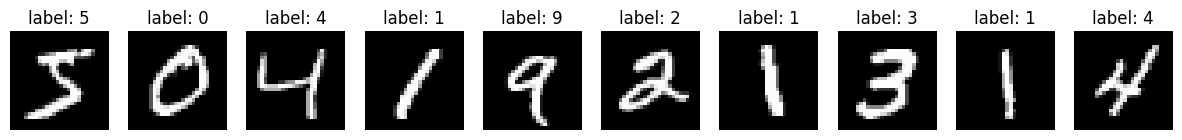

In [13]:
show_data(x_train, y_train, 10)

---


#### **3. Model and training**

###### **3.1. Model architecture**

The Keras model is built with the `Sequential` API consisting in stacking layers sequentially:

* `tf.keras.layers.Flatten`: convert a 2D tensor to a 1D tensor
* `tf.keras.layers.Dense`: layer of 128 neurons with ReLu function*
* `tf.keras.layers.Dropout`: prevent overfitting**
* `tf.keras.layers.Dense`: score output layer of 10 neurons
* `tf.keras.layers.Softmax`: convert a vector of logits into probabilities

Optimization is performed using the gradient descent SGD and the loss function considered is `SparseCategoricalCrossentropy`.

---

**The `Dense` neuron number is not optimized and is based on [[3]](https://www.tensorflow.org/tutorials/quickstart/beginner).*

***The dropout rate `DR` determines the probability of any given neuron being excluded temporaly from the neural network [[4]](https://www.scaler.com/topics/dropout-tensorflow/). At each training batch iteration, random neurons are desactivated and the model must learn redundant representations and rely on something other than specific neurons for accurate predictions.*

---

In [14]:
def create_model():
  DR = 0.2 # according to [4]
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Flatten(input_shape=(28, 28))) # (28, 28) --> (784, 1)
  model.add(tf.keras.layers.Dense(128, activation='relu'))
  model.add(tf.keras.layers.Dropout(DR))
  model.add(tf.keras.layers.Dense(10)) # output = score vector
  model.add(tf.keras.layers.Softmax()) # logits --> probability

  loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False) # loss function (outputs are not logits but proba)
  model.compile(optimizer="sgd", loss=loss_fn, metrics=['accuracy'])

  return model

In [15]:
model_MNIST = create_model()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


###### **3.2. Training phase**

The batch size is set to 32, a satisfactory balance between computational time and accurate gradient error. When the model is trained, the training accuracy is over 95%. No further training seems necessary after 15 epochs, or even improvement of the model architecture.




In [16]:
if training_phase == 'Yes':
  history = model_MNIST.fit(x_train, y_train, batch_size=32, epochs=15, verbose=1)
  model_MNIST.save("01_classification_image_digit.keras", include_optimizer=False) # save weights + architecture
else:
  results_MNIST, model_MNIST, model_MNIST_fashion = get_github_files()

Cloning into 'TensorFlow_duplicata'...
remote: Enumerating objects: 453, done.
remote: Counting objects: 100% (259/259), done.
remote: Compressing objects: 100% (171/171), done.
remote: Total 453 (delta 186), reused 88 (delta 88), pack-reused 194 (from 2)
Receiving objects: 100% (453/453), 91.47 MiB | 17.45 MiB/s, done.
Resolving deltas: 100% (226/226), done.


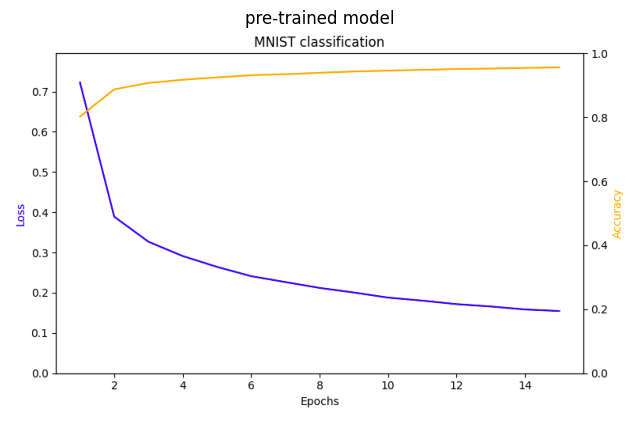

In [17]:
if training_phase == 'Yes':
  plot_evolution(history)
else:
  plt.figure(figsize=(8, 5))
  plt.imshow(results_MNIST)
  plt.title("pre-trained model"), plt.axis("off")
  plt.show()


---


#### **4. Evaluate the model**

Evaluation with unknown test data validates the model.

In [18]:
test_loss, test_acc = model_MNIST.evaluate(x_test,  y_test, verbose=0)
print("Test loss function value %0.1f and test accuracy value %0.1f %%" %(test_loss, 100*test_acc))

Test loss function value 0.1 and test accuracy value 96.4 %



---


#### **5. Digit recognition**

###### **5.1. Predictions**

By entering an index `i`, a test set element is predicted and compared with the true label.  

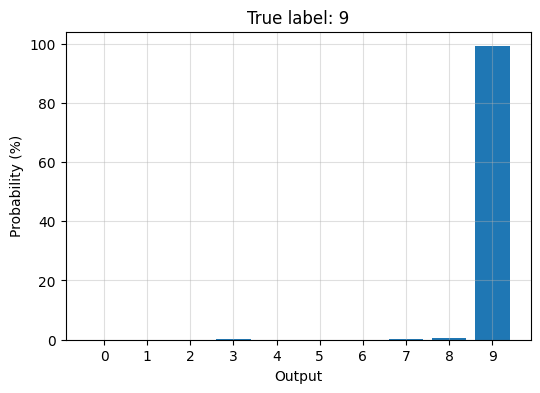

In [19]:
i = 273 # from 0 to 9,999

predictions = model_MNIST.predict(x_test, verbose=0) # make prediction
true_label = y_test[i]

show_proba(i, predictions[i], true_label, np.arange(0,10))

###### **5.2. Confusion matrix**

To visualize the 10,000 predictions made on the test set, the confusion matrix is computed. It is one of the tools used to validate classification models: the sum of the diagonal elements has to be close to or equal to the total number of predictions made (here 10,000).

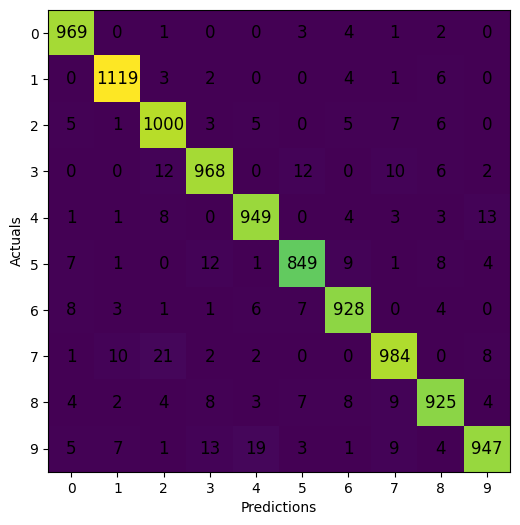

In [20]:
show_confusion_mat(y_test, predictions, np.arange(0,10))

**We can conclude that the MNIST classification model developed previously is fully acceptable.**

---


#### **6. Go further with the Fashion MNIST dataset**

To take this a step further, another database is used to train a model with optimal hyperparameters tuned:
* number of neurons in the `Dense` hidden layer
* learning rate of the SGD
* number of epochs during the training phase

###### **6.1. Retrieve data**

The database Fashion MNIST contained 70,000 labeled clothing images. Labels go from 0 to 9. Correspondence with clothing names is given by [[2]](https://www.kaggle.com/datasets/zalando-research/fashionmnist). Digital labels are mapped to clothing names given by `class_names`.

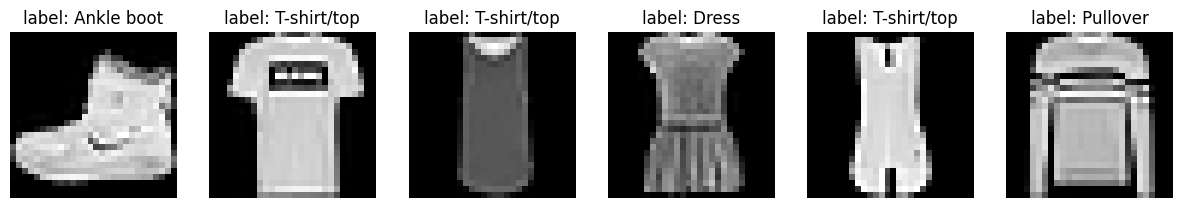

In [21]:
fashion_mnist = tf.keras.datasets.fashion_mnist # import fashion MNIST dataset

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
train_images, test_images = train_images / 255.0, test_images / 255.0 # pre-processing

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'] # label clothing names

train_labels = tf.cast(train_labels, tf.int32) # convert int8 into int32
train_labels_name = tf.gather(class_names, train_labels) # map class_names with train_labels
train_labels_name = [name.decode('utf-8') for name in train_labels_name.numpy()]

show_data(train_images, train_labels_name, 6)

###### **6.2. Model and optimization**

The following model has the same stacking approach as the previous one However, the number of neurons in the first full-connected layer `Dense` is optimized by testing different values of units. For this, a hyperparameter named `units` is created for an integer range from 256 to 512 neurons, with a step of 32.

The learning rate is also tested for 3 different values: 0.01, 0.001 and 0.0001.

In [22]:
def create_model_tune(hp):
  hp_units = hp.Int('units', min_value=256, max_value=512, step=32) # tune the number of neurons in the first dense layer (256 to 512)
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4]) # tune the learning rate for the gradient descent algorithm

  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Flatten(input_shape=(28, 28)))
  model.add(tf.keras.layers.Dense(units=hp_units, activation='relu'))
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Dense(10))

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

  return model

`Hyperband` is a hyperparametric search algorithm to build a model with different hyperparameter combinaisons [[5]](https://arxiv.org/pdf/1603.06560). At the beginning of the search process, `Hyperband` starts by training the model with a few epochs and then gradually increases the epoch (max 10) number for the most promising combinaisons (which maximizes `val_accuracy`) .

In [23]:
if training_phase == "Yes":
  tuner = kt.Hyperband(create_model_tune, objective='val_accuracy', max_epochs=10)

`EarlyStopping` is used to stop training the model if `val_loss` no longer improves and to restore the best weights.

In [24]:
if training_phase == "Yes":
  stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, min_delta=0.001)

In [25]:
if training_phase == "Yes":
  tuner.search(train_images, train_labels, validation_split=0.2, callbacks=[stop_early])

  best_hps=tuner.get_best_hyperparameters(num_trials=1)[0] # get the optimal hyperparameters

  print(f"""
  The hyperparameter search is complete. The optimal number of units in the first densely-connected
  layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
  is {best_hps.get('learning_rate')}.
  """)

###### **6.3. Training phase**

The number of epochs which maximizes `val_loss` is retained otherwise the model is trained for 50 epochs.

In [26]:
if training_phase == "Yes":
  hypermodel = tuner.hypermodel.build(best_hps)
  history = hypermodel.fit(train_images, train_labels, epochs=50, validation_split=0.2, callbacks=[stop_early], verbose=1)
  val_acc_per_epoch = history.history['val_accuracy']
  best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
  print('Best epoch: %d' % (best_epoch,))
  hypermodel.save('01_classification_image_fashion_model.keras') # save weights + architecture
else:
  hypermodel = model_MNIST_fashion

In [27]:
if training_phase == 'Yes':
  plot_evolution(history)

###### **6.4. Validation and comments**

In [28]:
test_loss, test_acc = hypermodel.evaluate(test_images,  test_labels, verbose=0)
print("Test loss function value %0.1f and test accuracy value %0.1f %%" %(test_loss, 100*test_acc))

Test loss function value 0.4 and test accuracy value 88.7 %


In [29]:
i = 12

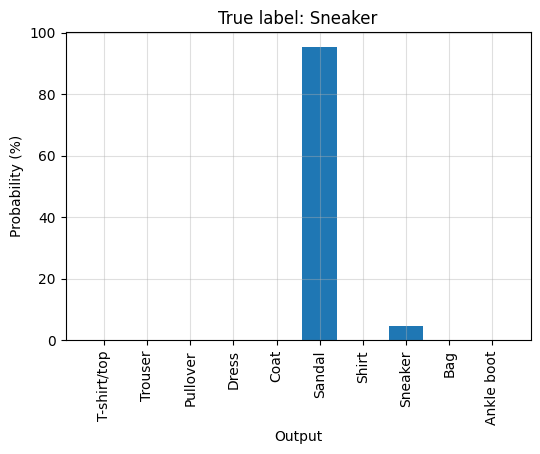

In [30]:
probability_hypermodel = tf.keras.Sequential([hypermodel, tf.keras.layers.Softmax()])

predictions = probability_hypermodel.predict(test_images, verbose=0) # output = probabilities
prediction_label = np.argmax(predictions[i])
true_label = test_labels[i]

show_proba_fashion(i, predictions[i,:], class_names[true_label], class_names)

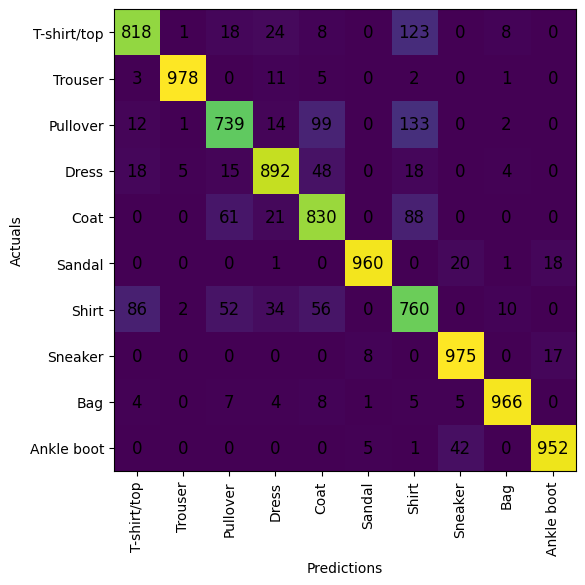

In [31]:
show_confusion_mat_fashion(test_labels, predictions, class_names)

Some confusions can be identified: T-shirt, shirt and sweater are sometimes confused due to their common shape. An extra training phase with additional features would be a good idea (sleeve size, shirt buttons, texture, etc.).

**With over 88% accuracy, the model is quite acceptable**

---


#### **7. Limitations**

The low image resolution helps the models to achieve a correct level of performance. For images with much higher resolutions, the size of the input vector exceeds one million - ten million for 8K resolution - and the number of weights becomes too high.

Models with a excessive unit number doesn't seem to be a suitable solution. The use of convolution layers in `04_convolution_CNN` provides satisfactory results for image classification with reasonable computation ressources.

---


#### **8. References**


| | | | | |
|------|------|------|------|------|
| Index | Title | Author(s) | Type | Comments |
|[[1]](https://www.kaggle.com/datasets/hojjatk/mnist-dataset) | MNIST digit dataset | Y. LeCun, C. Cortes, C.J.C. Burges | dataset | - |
|[[2]](https://www.kaggle.com/datasets/zalando-research/fashionmnist) | MNIST fashion dataset | MIT | dataset | - |
|[[3]](https://www.tensorflow.org/tutorials/quickstart/beginner?hl=fr) | Démarrage rapide de TensorFlow 2 pour les débutants | TensorFlow | Tutoriels | - |
|[[4]](https://dl.acm.org/doi/pdf/10.5555/2627435.2670313) | Dropout: A Simple Way to Prevent Neural Networks from Overfitting | G. Hinton & al | Paper | - |
|[[5]](https://arxiv.org/pdf/1603.06560) | Hyperband: A Novel Bandit-Based Approach to Hyperparameter Optimization | L. Li & al | Paper | - |
|[[6]](https://www.tensorflow.org/tutorials/keras/classification?hl=fr) | Classification de base : classer les images de vêtements | TensorFlow | Tutoriels | - |
|[[7]](https://www.tensorflow.org/tutorials/keras/keras_tuner?hl=fr) | Présentation de l'accordeur Keras | TensorFlow | Tutoriels | - |
|[[8]](https://www.tensorflow.org/tutorials/keras/save_and_load?hl=fr) | Enregistrer et charger des modèles | TensorFlow | Tutoriels | - |